In [165]:
###################################################################
# This is an official PyTorch implementation for Target-specific
# Generation of Molecules (TagMol)
# Author: Junde Li, The Pennsylvania State University
# Date: Aug 1, 2022
###################################################################

import os, time
import re
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.autograd as autograd
import pickle
from rdkit import Chem
from dataloader import *
from utils import *

In [186]:
# --------------------------
# Hyperparameters
# --------------------------

lr             = 1e-4
beta1          = 0.0
beta2          = 0.9
batch_size     = 16
max_epoch      = 400
num_workers    = 2
ligand_size    = 32
x_dim          = 1024
z_dim          = 128
save_step      = 100
conv_dims      = [1024, 2048, 2048, 1024]

atom_decoder = {0: 0, 1: 6, 2: 7, 3: 8, 4: 9, 5: 16, 6:17}
bond_decoder = {0: Chem.rdchem.BondType.ZERO,
                1: Chem.rdchem.BondType.SINGLE,
                2: Chem.rdchem.BondType.DOUBLE,
                3: Chem.rdchem.BondType.TRIPLE,
                4: Chem.rdchem.BondType.AROMATIC
                }
                

name           = "model/tagmol"
log_dir        = f"{name}"
models_dir     = f"{name}/saved_models"
device         = torch.device("cuda:0")

os.makedirs(log_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

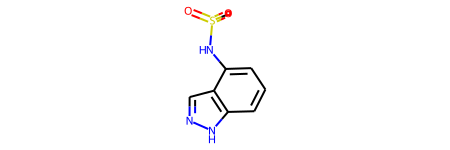

In [250]:
dataset = PDBbindPLDataset(root_dir='data/pdbbind/tiny-set',
                                n_points=5000, 
                                lig_size=14,
                                train=True,
                                transform=transforms.Compose([
                                    Normalize(),
                                    RandomRotateJitter(0.15),
                                    ToTensor()
                                ]))

dataloader = DataLoader(dataset, batch_size=2,
                        shuffle=True)

for i_batch, sample_batched in enumerate(dataloader):
    protein = sample_batched['protein']
    r_atoms, r_bonds = sample_batched['ligand']
    break

pid = '5l3a'
from rdkit.Chem.rdmolfiles import MolFromMol2File
ligand = MolFromMol2File(os.path.join('data/pdbbind/tiny-set', f'{pid}/{pid}_ligand.mol2'))
ligand

In [251]:
# --------------------------
# Define Encoder Network
# --------------------------

class STN(nn.Module):
    """Spatial transformer network for alignment"""

    def __init__(self, k):
        super(STN, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        identity = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1, self.k * self.k).repeat(
            batchsize, 1)
        if x.is_cuda:
            identity = identity.cuda()
        x = x + identity
        x = x.view(-1, self.k, self.k)
        return x


class PointNetEncoder(nn.Module):
    """PointNet Encoder Network for protein embedding."""

    def __init__(self, x_dim, channel=4, feature_transform=False):
        super(PointNetEncoder, self).__init__()
        self.stn = STN(k=3)

        self.conv1 = torch.nn.Conv1d(channel, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, x_dim, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(x_dim)
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STN(k=64)

    def forward(self, x):
        B, D, N = x.size()
        trans = self.stn(x[:,:3,:]) # channel=3 only
        x = x.transpose(2, 1)
        if D > 3:
            feature = x[:, :, 3:]
            x = x[:, :, :3]
        x = torch.bmm(x, trans) # shape=(B, N, 3)

        if D > 3:
            x = torch.cat([x, feature], dim=2)
        x = x.transpose(2, 1) # shape=(B, D, N)
        x = F.relu(self.bn1(self.conv1(x))) # shape=(B, 64, N)

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2, 1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2, 1)
        
        x = F.relu(self.bn2(self.conv2(x))) # shape=(B, 128, N)
        x = self.bn3(self.conv3(x)) # shape=(B, x_dim, N)
        # Aggregate point features by max pooling.
        x = torch.max(x, 2, keepdim=True)[0] # shape=(B, x_dim)
        x = x.view(-1, x_dim)
        
        return x


class Generator(nn.Module):
    """Network for generating probabilistic distribution of ligands."""

    def __init__(self, x_dim, z_dim, conv_dims, ligand_size, dataset):
        super(Generator, self).__init__()

        self.n_atom_types = len(dataset.atom_encoder)
        self.n_bond_types = len(dataset.bond_encoder)
        self.ligand_size = ligand_size

        layers = []
        for c0, c1 in zip([x_dim+z_dim]+conv_dims[:-1], conv_dims):
            layers.append(nn.Linear(c0, c1))
            layers.append(nn.BatchNorm1d(c1, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.layers = nn.Sequential(*layers)

        self.atom_layer = nn.Sequential(
                          nn.Linear(conv_dims[-1], 2048),
                          nn.LeakyReLU(0.2, inplace=True),
                          nn.Linear(2048, self.ligand_size * self.n_atom_types),
                          nn.Dropout(p=0.2)
                          )
        self.bond_layer = nn.Sequential(
                          nn.Linear(conv_dims[-1], 2048),
                          nn.LeakyReLU(0.2, inplace=True),
                          nn.Linear(2048, self.ligand_size * self.ligand_size * self.n_bond_types),
                          nn.Dropout(p=0.2)
                          )

    def forward(self, x, z):
        # Concatenate protein embedding and noise.
        gen_input = torch.cat((x, z), -1)

        # Generate atoms and bonds.
        out = self.layers(gen_input)
        atoms = self.atom_layer(out).view(-1, self.ligand_size, self.n_atom_types)
        atoms = nn.Softmax(dim=-1)(atoms)

        bonds = self.bond_layer(out).view(-1, self.ligand_size, self.ligand_size, self.n_bond_types)
        bonds = (bonds + bonds.permute(0, 2, 1, 3)) / 2.0
        bonds = nn.Softmax(dim=-1)(bonds)

        return atoms, bonds

class GATLayer(nn.Module):
    """Single-head GAT layer for passing messages with dynamical weights."""

    def __init__(self, c_in, c_out, n_relations):
        """
        Args:
            c_in - Dimensionality of input features
            c_out - Dimensionality of output features
            n_realtions - Number of relation types between atoms
        """
        super(GATLayer, self).__init__()
        self.n_relations = n_relations

        # Tranaform node_feats to c_out dimenional messages.
        self.projection = nn.Linear(c_in, c_out*n_relations)
        self.a = nn.Parameter(torch.Tensor(n_relations, 2*c_out))

        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, atoms, bonds):
        """
        Args:
            atoms - One-hot encoded input features of atom nodes. Shape = (B, ligand_size, c_in)
            bonds - One-hot encoded adjacency matrix including self-connections.
                    Shape = (B, ligand_size, ligand_size)
        """
        bs, n_nodes = atoms.size(0), atoms.size(1)
        node_feats = self.projection(atoms)
        node_feats = node_feats.view(bs, n_nodes, self.n_relations, -1)

        # Calculate the attention logits for evey bond in the ligand.
        # Create a tensor of [W_r*h_i||W_r*h_j] with i and j being the indices of all bonds
        edges = bonds.nonzero(as_tuple=False) # shape=(b, n_nodes, n_nodes, r)
        node_feats_flat = node_feats.view(bs * n_nodes, self.n_relations, -1)
        edge_indices_row = edges[:,0] * n_nodes + edges[:,1]
        edge_indices_col = edges[:,0] * n_nodes + edges[:,2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat, index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim=0)
        ], dim=-1) # return concatenated node_feats indiced by i and j. shape = (n_nodes*n_nodes, r, 2*c_out)

        # Calculate attention logit alpha(i, j) for each relation.
        attn_logits = torch.einsum('brc,rc->br', a_input, self.a) # shape=(n_nodes*n_nodes, r)
        attn_logits = nn.LeakyReLU(0.2)(attn_logits)

        # Create attention matrix according to relation types.
        attn_matrix = attn_logits.new_zeros(bonds.shape).fill_(-9e15) # shape=(b, n_nodes, n_nodes, r)
        attn_matrix[bonds==1] = torch.gather(attn_logits, 1, edges[:, -1].view(-1, 1)).view(-1)

        # Calculate softmax across bonds with all types.
        attn_matrix = attn_matrix.view(bs, n_nodes, -1)
        attn_probs = F.softmax(attn_matrix, dim=2).view(bs, n_nodes, n_nodes, self.n_relations)

        # Sum over neighbors with all relations.
        node_feats = torch.einsum('bijr, bjrc->bic', attn_probs, node_feats)

        return node_feats


class Discriminator(nn.Module):
    """Discriminator with GATLayer for evaluating EM distance btw real and fake ligands."""

    def __init__(self, c_in, c_out, c_hidden=None, n_relations=5, n_layers=3):
        """
        Args:
            c_in - Dimension of input features
            c_out - Dimension of output features
            c_hidden - Dimension of hidden features
            n_relations - Number of bond relations between atoms
            n_layers - Number of GAT graph layers
        """
        super(Discriminator, self).__init__()
        c_hidden = c_hidden if c_hidden else c_out

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for _ in range(n_layers-1):
            layers += [
                GATLayer(in_channels, out_channels, n_relations),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2)
            ]
            in_channels = c_hidden

        layers.append(GATLayer(in_channels, c_out, n_relations))
        self.layers = nn.ModuleList(layers)

        self.validity_layer = nn.Sequential(
                                    nn.Linear(2*c_out, c_out),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.2),
                                    nn.Linear(c_out, 1)
                                )

    def forward(self, ligand):
        """
        Args:
            x - Input features of one-hot encoded atom vector
            adj - Ligand structure features of one-hot encoded bond adjacency matrix
        """
        x, adj = ligand
        for l in self.layers:
            if isinstance(l, GATLayer):
                x= l(x, adj)
            else:
                x = l(x)

        # Aggregate mean and max features across all nodes.
        h = torch.cat((torch.mean(x, 1), torch.max(x, 1)[0]), 1)
        out = self.validity_layer(h)

        return out


class EnergyModel(nn.Module):
    """Energy-based network for measuring relative binding affinity btw protein and ligand."""

    def __init__(self, x_dim, c_in, c_out, c_hidden=None, n_relations=5, n_layers=3):
        """
        Args:
            x_dim - Dimension of extracted protein features
            c_in - Dimension of input features
            c_out - Dimension of output features
            c_hidden - Dimension of hidden features
            n_relations - Number of bond relations between atoms
            n_layers - Number of GAT graph layers
        """
        super(EnergyModel, self).__init__()
        c_hidden = c_hidden if c_hidden else c_out

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for _ in range(n_layers-1):
            layers += [
                GATLayer(in_channels, out_channels, n_relations),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2)
            ]
            in_channels = c_hidden

        layers.append(GATLayer(in_channels, c_out, n_relations))
        self.layers = nn.ModuleList(layers)

        self.energy_layer = nn.Sequential(
                                    nn.Linear(2*c_out+x_dim, 256),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Linear(256, 32),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Linear(32, 1)
                                )

    def forward(self, x, y_atoms, y_bonds):
        """
        Args:
            x - Protein features extracted from PointNetEncoder
            y_atoms - Input features of one-hot encoded atom vector
            y_bonds - Ligand structure features of one-hot encoded bond adjacency matrix
        """
        for l in self.layers:
            if isinstance(l, GATLayer):
                y_atoms= l(y_atoms, y_bonds)
            else:
                y_atoms = l(y_atoms)

        # Aggregate mean and max features across all nodes.
        y_feats = torch.cat((torch.mean(y_atoms, 1), torch.max(y_atoms, 1)[0]), 1)

        # Fuse features from protein and ligand.
        h = torch.cat((x, y_feats), 1)
        out = self.energy_layer(h)

        return out


class RewardModel(nn.Module):
    """Reward network for evaluating ligand properties of QED, logP and SA."""

    def __init__(self, c_in, c_out, c_hidden=None, n_relations=5, n_layers=3):
        """
        Args:
            c_in - Dimension of input features
            c_out - Dimension of output features
            c_hidden - Dimension of hidden features
            n_relations - Number of bond relations between atoms
            n_layers - Number of GAT graph layers
        """
        super(RewardModel, self).__init__()
        c_hidden = c_hidden if c_hidden else c_out

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for _ in range(n_layers-1):
            layers += [
                GATLayer(in_channels, out_channels, n_relations),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2)
            ]
            in_channels = c_hidden

        layers.append(GATLayer(in_channels, c_out, n_relations))
        self.layers = nn.ModuleList(layers)

        self.property_layer = nn.Sequential(
                                    nn.Linear(2*c_out, c_out),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.2),
                                    nn.Linear(c_out, 3)
                                )

    def forward(self, x, adj):
        """
        Args:
            x - Input features of one-hot encoded atom vector
            adj - Ligand structure features of one-hot encoded bond adjacency matrix
        """
        for l in self.layers:
            if isinstance(l, GATLayer):
                x= l(x, adj)
            else:
                x = l(x)

        # Aggregate mean and max features across all nodes.
        h = torch.cat((torch.mean(x, 1), torch.max(x, 1)[0]), 1)
        properties = self.property_layer(h)

        return properties

In [252]:
encoder = PointNetEncoder(x_dim, channel=4, feature_transform=True)
x = encoder(protein.transpose(2, 1))
z = torch.rand(2, 128)

generator = Generator(x_dim, z_dim, conv_dims, 9, dataset)
f_atoms, f_bonds = generator(x, z)

# Hard categorical sampling fake ligands from probabilistic distribution.
f_atoms = F.gumbel_softmax(f_atoms, tau=1, hard=True)
f_bonds = F.gumbel_softmax(f_bonds, tau=1, hard=True)
discriminator = Discriminator(c_in=7, c_out=32, c_hidden=64, n_relations=5, n_layers=3)
r_validity = discriminator((r_atoms, r_bonds))
f_validity = discriminator((f_atoms, f_bonds))

energy_model = EnergyModel(x_dim, c_in=7, c_out=128, n_relations=5, n_layers=3)
out = energy_model(x, r_atoms, r_bonds)

reward_model = RewardModel(c_in=7, c_out=32, c_hidden=64, n_relations=5, n_layers=3)
properties = reward_model(r_atoms, r_bonds)

In [253]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

def compute_gradient_penalty(discriminator, r_atoms, r_bonds, f_atoms, f_bonds):
    """Calculates the gradient penalty (L2_norm(dy/dx) - 1)**2"""
    # Random weight term for interpolation between real and fake samples
    alpha_atoms = Tensor(np.random.random((r_atoms.size(0), 1, 1)))
    alpha_bonds = alpha_atoms.unsqueeze(-1)
    # Get random interpolation between real and fake samples
    interp_atoms = (alpha_atoms * r_atoms + (1 - alpha_atoms) * f_atoms).requires_grad_(True)
    interp_bonds = (alpha_bonds * r_bonds + (1 - alpha_bonds) * f_bonds).requires_grad_(True)

    interp_atoms = F.gumbel_softmax(interp_atoms, tau=1, hard=True)
    interp_bonds = F.gumbel_softmax(interp_bonds, tau=1, hard=True)

    interp_validity = discriminator((interp_atoms, interp_bonds))
    fake = Variable(Tensor(r_atoms.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=interp_validity,
        inputs=(interp_atoms, interp_bonds),
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
        allow_unused=True # adj gradients not used in GATLayer
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [254]:
def compute_rdkit_property(r_atoms, r_bonds, f_atoms, f_bonds):
    pass

In [255]:
def matrices2mol(node_labels, edge_labels, strict=False):
    mol = Chem.RWMol()

    for node_label in node_labels:
        mol.AddAtom(Chem.Atom(atom_decoder[node_label]))

    for start, end in zip(*np.nonzero(edge_labels)):
        if start > end:
            mol.AddBond(int(start), int(end), bond_decoder[edge_labels[start, end]])

    if strict:
        try:
            Chem.SanitizeMol(mol)
        except:
            mol = None

    return mol

In [256]:
r_edges, r_nodes = torch.max(r_bonds, -1)[1], torch.max(r_atoms, -1)[1]

In [257]:
mols = [matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True)
                        for e_, n_ in zip(r_edges, r_nodes)]

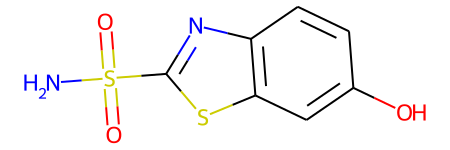

In [260]:
mols[1]